In [60]:
import math
import string
from functools import reduce

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.random import randint
from random import seed,random
import plotly.express as px
from IPython.display import display
from pandas import DataFrame
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler, StandardScaler

### Importing S&P 500 Daily time series

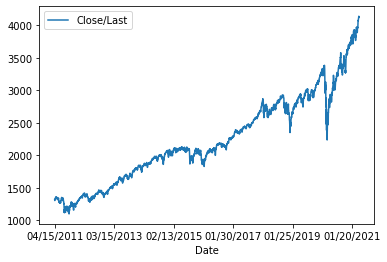

Length: 2560


In [61]:
spx_short = pd.read_csv('../data/spx_daily_11-21.csv', usecols=[0,1])
spx_short['Close/Last']=spx_short['Close/Last'].astype(int)
spx_short=spx_short.iloc[::-1]
spx_short.plot(x='Date', y='Close/Last')
plt.show()
np_spx_short = spx_short['Close/Last'].to_numpy()
print('Length: '+str(np_spx_short.shape[0]))

### Importing S&P 500 all time Monthly time series over 200 years

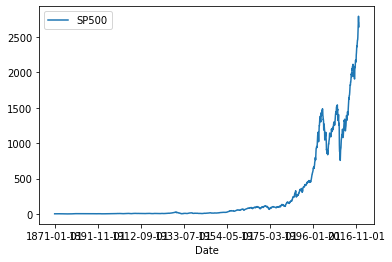

Length: 1768


In [62]:
spx_long = pd.read_csv('../data/spx_monthly_alltime.csv', usecols=[0,1])
spx_long.plot(x='Date', y='SP500')
plt.show()
np_spx_long = spx_long['SP500'].to_numpy()
print('Length: '+str(np_spx_long.shape[0]))

### Importing minimum temperature dataset

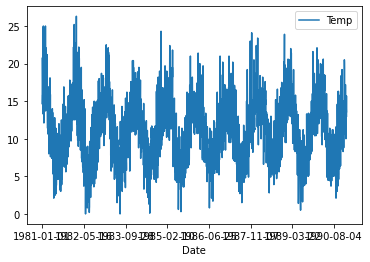

Length: 3650


In [63]:
min_daily_temp = pd.read_csv('../data/daily-minimum-temperatures-in-melbourne.csv',usecols=[0,1])
#min_daily_temp['Temp'] = min_daily_temp['Temp'].apply(pd.to_numeric,errors='coerce')
min_daily_temp.plot(x='Date', y='Temp')
plt.show()
np_min_daily_temp = min_daily_temp['Temp'].to_numpy()
print('Length: '+str(np_min_daily_temp.shape[0]))

### Importing german BIP

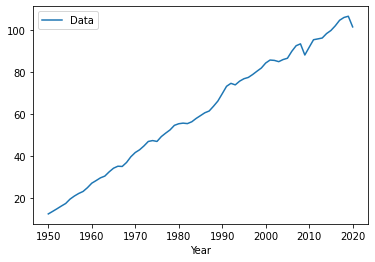

Length: 71


In [64]:
bip_de = pd.read_csv('../data/bip_de_preisbereinigt.csv',sep=';',usecols=[0,1])
bip_de.plot(x='Year', y='Data')
plt.show()
np_bip_de = bip_de['Data'].to_numpy()
print('Length: '+str(np_bip_de.shape[0]))

### Importing german DAX 2021

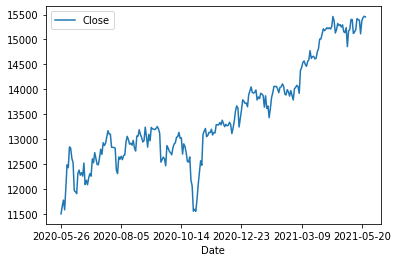

Length: 254


In [65]:
dax = pd.read_csv('../data/dax.csv', usecols=[0,4])
dax.plot(x='Date', y='Close')
plt.show()
np_dax = dax['Close'].to_numpy()
print('Length: '+str(np_dax.shape[0]))

### Importing german DAX alltime

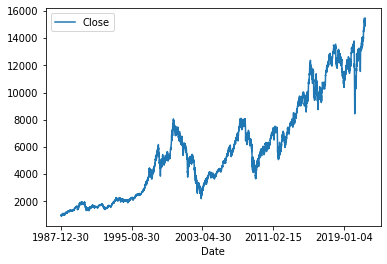

Length: 8602


In [66]:
dax_alltime = pd.read_csv('../data/dax_alltime.csv', usecols=[0,4])
dax_alltime.plot(x='Date', y='Close')
plt.show()
np_dax_alltime = dax_alltime['Close'].to_numpy()

for i in range(np_dax_alltime.shape[0]):
    if math.isnan(np_dax_alltime[i]):
        np_dax_alltime[i] = np_dax_alltime[i-1]

print('Length: '+str(np_dax_alltime.shape[0]))

### Importing german Bitcoin alltime

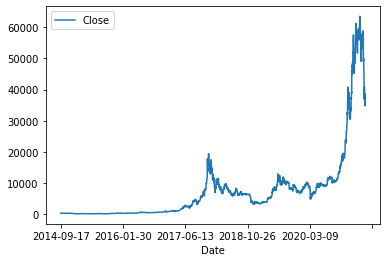

Length: 2444


In [67]:
bitcoin_alltime = pd.read_csv('../data/bitcoin_alltime.csv', usecols=[0,4])
bitcoin_alltime.plot(x='Date', y='Close')
plt.show()
np_bitcoin_alltime = bitcoin_alltime['Close'].to_numpy()

for i in range(np_bitcoin_alltime.shape[0]):
    if math.isnan(np_bitcoin_alltime[i]):
        np_bitcoin_alltime[i] = np_bitcoin_alltime[i-1]

print('Length: '+str(np_bitcoin_alltime.shape[0]))

In [68]:
def create_random_walk(ts: np.array):
    """

    :param ts:
    :return:
    """
    ma = np.amax(ts)
    mi = np.amin(ts)
    seed(randint(mi,ma))
    random_walk = list()

    random_walk.append(randint(mi,ma))
    for i in range(1, ts.shape[0]):
	    r = randint(0,9)
	    movement = r if random() < 0.5 else -r
	    value = random_walk[i-1] + movement
	    random_walk.append(value)

    return np.array(random_walk)

In [69]:
def to_sts_matrix(ts: np.array, w: int):
    shape = ts.shape[:-1] + (ts.shape[-1] - w + 1, w)
    strides = ts.strides + (ts.strides[-1],)
    return np.lib.stride_tricks.as_strided(ts, shape=shape, strides=strides)


def to_random_sampling_matrix(ts: np.array, w: int, reduced_sampling_size=False):
    m = ts.shape[0]
    num_samples = m//w if reduced_sampling_size else m - w + 1
    data_matrix = np.zeros((num_samples, w), dtype=int)


    for i in range(num_samples):
        r = randint(0, m - w)
        for j in range(w):
            data_matrix[i][j] = ts[r+j]

    return data_matrix

In [70]:
def cluster_distance(a: np.array, b: np.array, dist_metric_name: string):
    """

    :param dist_metric_name:
    :param a: cluster centres derived from one run of clustering algor (shape: [k,w])
    :param b: cluster centres derived from different run of clustering algor (shape: [k,w])
    :return:
    """
    assert a.shape[1] != 0
    summ = 0
    n = a.shape[0]

    for i in range(n):
        f = lambda x: distance_metric(a[i],x,dist_metric_name)
        summ += np.amin(np.array(list(map(f,b))))

    return summ


def within_set_distance(x: np.array, dist_metric_name: string):
    """

    :param dist_metric_name:
    :param x: set of cluster centers (shape: [n,k,w])
    :return:
    """
    n = x.shape[0]
    summ = 0
    for i in range(n):
        for j in range(n):
            summ += cluster_distance(x[i], x[j], dist_metric_name)
    return summ/n**2


def between_set_distance(x: np.array, y: np.array, dist_metric_name: string):
    """

    :param dist_metric_name:
    :param x:
    :param y:
    :return:
    """
    n = x.shape[0]
    m = y.shape[0]
    summ = 0
    for i in range(n):
        for j in range(m):
            summ += cluster_distance(x[i], y[j], dist_metric_name)
    return summ/(n*m)


def clustering_meaningfulness(x: np.array, y: np.array, dist_metric_name: string):
    """

    :param dist_metric_name:
    :param x:
    :param y:
    :return:
    """
    return within_set_distance(x,dist_metric_name)/between_set_distance(x,y,dist_metric_name)

In [71]:
def calculate_meaningfulness(ts: np.array, random_walk: np.array, n: int, k: int, w: int, r: int, normalizer: string,
                             dist_metric_name: string, cluster_algor_name: string, reduced_sampling_size: bool,
                             dim_red: bool):
    """

    :param normalizer:
    :param reduced_sampling_size:
    :param dist_metric_name:
    :param cluster_algor_name:
    :param random_walk:
    :param ts:
    :param n:
    :param k:
    :param w:
    :param r:
    :return:
    """
    meaningfulness_sts = 0
    meaningfulness_whole = 0

    sts_ts_matrix = to_sts_matrix(ts, w)
    sts_ts_matrix = scale_feature_matrix(sts_ts_matrix, normalizer)

    whole_ts_matrix = to_random_sampling_matrix(ts, w, reduced_sampling_size)
    whole_ts_matrix = scale_feature_matrix(whole_ts_matrix, normalizer)

    sts_random_matrix = to_sts_matrix(random_walk, w)
    sts_random_matrix = scale_feature_matrix(sts_random_matrix, normalizer)

    whole_random_matrix = to_random_sampling_matrix(random_walk, w, reduced_sampling_size)
    whole_random_matrix = scale_feature_matrix(whole_random_matrix, normalizer)

    #pca
    if dim_red & w>8:
        sts_ts_matrix = PCA(n_components='mle').fit_transform(sts_ts_matrix)
        whole_ts_matrix = PCA(n_components='mle').fit_transform(whole_ts_matrix)
        sts_random_matrix = PCA(n_components='mle').fit_transform(sts_random_matrix)
        whole_random_matrix = PCA(n_components='mle').fit_transform(whole_random_matrix)



    for _ in range(n):
        sts_ts_kmeans_centers = np.zeros((r,k,w))
        whole_ts_kmeans_centers = np.zeros((r,k,w))
        sts_random_kmeans_centers = np.zeros((r,k,w))
        whole_random_kmeans_centers = np.zeros((r,k,w))

        for i in range(r):
            sts_ts_kmeans_centers[i] = cluster_functions(sts_ts_matrix,k,cluster_algor_name)
            whole_ts_kmeans_centers[i] = cluster_functions(whole_ts_matrix,k,cluster_algor_name)
            sts_random_kmeans_centers[i] = cluster_functions(sts_random_matrix,k,cluster_algor_name)
            whole_random_kmeans_centers[i] = cluster_functions(whole_random_matrix,k,cluster_algor_name)

        meaningfulness_sts += clustering_meaningfulness(sts_ts_kmeans_centers, sts_random_kmeans_centers, dist_metric_name)
        meaningfulness_whole += clustering_meaningfulness(whole_ts_kmeans_centers, whole_random_kmeans_centers, dist_metric_name)

    return meaningfulness_sts/n, meaningfulness_whole/n

In [72]:
def distance_metric(v: np.array, w: np.array, metric_name='eukl'):
    if metric_name == 'eukl':
        return np.linalg.norm(v-w)

In [73]:
def scale_feature_matrix(m: np.array, typ="none"):
    if typ == "none":
        return m
    if typ == "snd":
        scaler = StandardScaler()
        return scaler.fit_transform(m)
    if typ == "min-max":
        scaler = MinMaxScaler()
        return scaler.fit_transform(m)

In [74]:
# kmeans init: 'random' or 'k-means++'
# gmm init_param: 'kmeans' or 'random'
def cluster_functions(feature_matrix: np.array, k: int, algor_name: string):
    """

    :param feature_matrix:
    :param k:
    :param algor_name:
    :return:
    """
    if algor_name == 'kmeans':
        return KMeans(n_clusters=k, init='random', n_init=1, max_iter=100).fit(feature_matrix).cluster_centers_

    if algor_name == 'agglo':
        labels = AgglomerativeClustering(n_clusters=k).fit(feature_matrix).labels_
        counts = np.zeros(k)
        centroids = np.zeros((k,feature_matrix.shape[1]))
        for l,v in zip(labels,feature_matrix):
            counts[l] += 1
            centroids[l] += v
        for i in range(k):
            centroids[i] = centroids[i] / counts[i]
        return centroids

    if algor_name == 'gmm':
        return GaussianMixture(n_components=k, max_iter=100, init_params='kmeans').fit(feature_matrix).means_

In [77]:
n = 10
r = 3
ks = np.array([3,5,7,11])
ws = np.array([8,16,32])

normalizers = ['none','snd','min-max']
cluster_algos = ['kmeans','agglo','gmm']
distance_metrics = ['eukl']
time_series = [np_spx_short,
               np_spx_long,
               np_min_daily_temp,
               np_bip_de,
               np_dax,
               np_dax_alltime,
               np_bitcoin_alltime]

current_normalizer = normalizers[2]
# used clustering algorithm
current_cluster_algo = cluster_algos[0]
# used time series
current_time_series = time_series[0]

current_distance_metric = distance_metrics[0]

# reduces de sampling size of the random sampled subsequences that are used for whole clustering
# if false the random samples matrix has the same height as the sts matrix
reduced_sampling_size = True
dim_red = False


# Here it begins
meaningfulness_sts = []
meaningfulness_whole = []

random_walk = create_random_walk(current_time_series)
# or other opposing timeseries
random_walk = time_series[5]


print("n: "+str(n)+", r: "+str(r))
for k in ks:
    for w in ws:
        sts,whole = calculate_meaningfulness(ts=current_time_series, random_walk=random_walk, n=n, k=k, w=w, r=r,
                                             normalizer=current_normalizer, dist_metric_name=current_distance_metric,
                                             cluster_algor_name=current_cluster_algo,
                                             reduced_sampling_size=reduced_sampling_size,
                                             dim_red=dim_red)
        meaningfulness_sts.append([w,k,sts])
        meaningfulness_whole.append([w,k,whole])
        print("k="+str(k)+", w="+str(w)+" -- STS: "+str(sts)+", Whole: "+str(whole)+"")

df_sts = pd.DataFrame(meaningfulness_sts, columns=['window_size','k','meaningfulness_sts'])
df_whole = pd.DataFrame(meaningfulness_whole, columns=['window_size','k','meaningfulness_whole'])

join_keys = ['window_size','k']
df_meaningfulness = pd.merge(left=df_sts, right=df_whole, right_on=join_keys, left_on=join_keys)
#display(df_meaningfulness)

df = df_meaningfulness.melt(id_vars=['window_size', 'k'])
px.bar(df, x='k', y='value', color='variable', barmode='group', facet_col='window_size')






n: 10, r: 3
k=3, w=8 -- STS: 0.22994964300673842, Whole: 0.3620273148966402
k=3, w=16 -- STS: 0.4067815802427308, Whole: 0.27282666349481033
k=3, w=32 -- STS: 0.2357757758904618, Whole: 0.31869096242107275
k=5, w=8 -- STS: 0.3793806362318749, Whole: 0.5743770294102878
k=5, w=16 -- STS: 0.23661454464046705, Whole: 0.26039270741483145
k=5, w=32 -- STS: 0.2295784478633128, Whole: 0.28359866997805094
k=7, w=8 -- STS: 0.4320020506243556, Whole: 0.5588067297486508
k=7, w=16 -- STS: 0.5081215666758262, Whole: 0.3731634412568698
k=7, w=32 -- STS: 0.5761032238279451, Whole: 0.3670544897743352
k=11, w=8 -- STS: 0.37934577932502933, Whole: 0.49709170769562966
k=11, w=16 -- STS: 0.37895850770045514, Whole: 0.4335542725029371
k=11, w=32 -- STS: 0.4350725827686614, Whole: 0.3784234740869837
